In [1]:
import os
os.chdir("./PMBO") #you own PMBO download path

In [2]:
import math
import torch
import gpytorch
import warnings
warnings.filterwarnings("ignore")  

In [3]:
import time
import pandas as pd
import numpy as np

In [6]:
from utility import centering,paretoOpt,Initialdata_Preparation
from hypervolume import InnerHyperVolume
from log import log
from optimize import MBO_opt

In [9]:
df= pd.read_csv(r'../example.csv',index_col=0)
df

,ID,SMILES,RI,Tg,TC,MW_ratio,Mass_ave,K_bond_min,K_bond_ave,K_ang_ave,...,AATSC2Z,BCUTd-1h,BCUTZ-1h,nHBDon,MIC0,Kier3,Mor02,Mor19,SMR_VSA1,SMR_VSA3
0,PI1,*CC*,1.512,-41.444976,0.456185,1.000000,4.675667,218.51,325.816667,48.657000,...,-1.833333,2.111099,6.102019,0,6.509500,4.000000,13.561131,0.205252,0.000000,0.000000
1,PI2,*C(C*)C,1.491,-12.961252,0.258773,0.666667,4.675667,218.51,326.680000,49.103167,...,-1.593205,3.021853,6.150638,0,6.621049,4.000000,19.229187,0.421298,0.000000,0.000000
2,PI3,*C(C*)CC,1.475,-17.648048,0.264363,0.500000,4.675667,218.51,327.040000,48.953250,...,-1.388605,3.025654,6.168683,0,6.667362,3.000000,21.929279,0.350261,0.000000,0.000000
3,PI4,*C(C*)CCC,1.467,-28.994172,0.261131,0.400000,4.675667,218.51,327.256000,48.866333,...,-1.310727,3.025703,6.178959,0,6.690928,3.840000,24.753693,0.823443,0.000000,0.000000
4,PI5,*C(C*)C(C)C,1.456,31.319970,0.234342,0.400000,4.675667,218.51,327.256000,49.203833,...,-0.477393,3.113397,6.196681,0,6.690928,2.666667,25.662506,0.819376,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1070,PI1213,[*]C=Cc1ccc(C=Cc2nc3cc4nc([*])[nH]c4cc3[nH]2)cc1,1.849,291.213887,0.893000,1.000000,8.362412,349.52,392.020526,65.666710,...,-0.009160,3.214789,7.073043,2,11.471507,4.065600,35.885536,-0.125057,0.000000,19.935914
1071,PI1214,[*]Nc1ccc(-c2ccc(NC3=CC(=O)C([*])=CC3=O)cc2)cc1,1.735,228.347696,0.379000,1.000000,8.479588,277.60,393.051351,63.475111,...,-0.111111,3.158248,8.023216,2,13.489312,4.803403,30.533248,0.116230,9.589074,0.000000
1072,PI1215,[*]NC1=CC(=O)C([*])=CC1=O,1.657,164.128637,0.347000,1.000000,10.091250,295.35,412.541539,68.149649,...,0.605442,3.156103,8.023195,1,16.998058,1.975309,13.480738,0.013218,9.589074,5.733667
1073,PI1216,[*]Nc1ccc([*])nc1,1.683,150.099978,0.398000,1.000000,8.372818,349.52,396.544167,67.789316,...,-0.719091,3.059415,7.044647,1,12.714831,2.000000,14.627242,-0.196078,0.000000,4.983979


In [10]:
RI_feature=['MW_ratio', 'Mass_ave', 'K_bond_min', 'K_bond_ave',
           'K_ang_ave', 'Theta0_ave', 'K_dih_max', 'K_dih_ave', 'VE1_A', 'AATS0d',
           'AATS0Z', 'BalabanJ', 'HybRatio', 'SaasC', 'ETA_dBeta', 'IC1', 'IC3',
           'MIC1', 'Mor14', 'SMR_VSA5', 'VSA_EState4', 'VSA_EState8']
Tg_feature=['K_bond_ave', 'Theta0_ave', 'VR3_A', 'nN', 'AATS0d',
           'AATS2d', 'ATSC1d', 'ATSC3d', 'BalabanJ', 'Xch-6d', 'IC3',
           'SlogP_VSA1']
TC_feature=['Monomer_length', 'MW_ratio', 'Mass_max',
           'Mass_ave', 'K_bond_ave', 'K_ang_ave', 'nH', 'AATS0d', 'AATS0Z',
           'ATSC2Z', 'ATSC5Z', 'AATSC0Z', 'AATSC2Z', 'BCUTd-1h', 'BCUTZ-1h',
           'nHBDon', 'MIC0', 'MIC1', 'Kier3', 'Mor02', 'Mor14', 'Mor19',
           'SMR_VSA1', 'SMR_VSA3', 'VSA_EState4']

In [11]:
X_RI=df[RI_feature]
X_Tg=df[Tg_feature]
X_TC=df[TC_feature]
Y_RI=df["RI"].values
Y_Tg=df["Tg"].values
Y_TC=df["TC"].values
Xinfo = df['ID']
Xdata= np.hstack((X_RI.values,X_Tg.values,X_TC.values))
X_layer=np.vstack((0,X_RI.shape[1],X_Tg.shape[1],X_TC.shape[1])).T
Ydata = np.vstack((Y_RI,Y_Tg,Y_TC)).T

In [12]:
X_all=centering(Xdata)

In [14]:
n_layer=np.sum(X_layer)
nobj=Ydata.shape[1]
random_data=20
seed=2
Multiprobe=5
Nruns=16
metr = 'crowdingDistance'

In [15]:
ref_point=[1.85,405.65,1.08]
HV = InnerHyperVolume(ref_point)
Paretoloc, ybestloc = paretoOpt(Ydata,metric=metr,opt='max') 
volumemax=HV.compute(Ydata[Paretoloc])

In [16]:
YOPTID=[]
HyperVolume=[]
start = time.perf_counter()
log(True)
print ("Randomly selected %d data for initial training " %(random_data))
Xtrain,XtraininfoIni,Ytrain,Xremain,XremaininfoIni,Yremain  =Initialdata_Preparation (X_all,Xinfo,Ydata,random_data,n_layer,nobj,seed)
Paretoloc, ybestloc = paretoOpt(Ytrain,metric=metr,opt='max') 
Calpoly=Ytrain
CalpolyID=XtraininfoIni
YOPT=Ytrain[Paretoloc]
volume=HV.compute(YOPT)
HyperVolume.append(volume/volumemax)
ybest=Ytrain[ybestloc]
ybestid=XtraininfoIni[ybestloc]
YBESTID=ybestid
YBEST=ybest
Calpoly=Ytrain
CalpolyID=XtraininfoIni
print ("The best from random datasets\n polymer_ID: %s   RI: %f   Tg: %f   TC:%f \n" %(ybestid,ybest[0],ybest[1],ybest[2]))
print ("\033[1mCurrent hyperparameter volume is\033[0m %f \n" %(HyperVolume[-1]))
for iii in range(Nruns):
    print ("Multi-objective optimization #RUN %d" %(iii+1))
    Xtrainnew,XtraininfoIninew,Ytrainnew,Xremainnew,XremaininfoIninew,Yremainnew,Xexplored,Xexploredinfo,Yexplored,ybestnew,ybestidnew,result=\
MBO_opt(Xtrain,XtraininfoIni,Ytrain,Xremain,XremaininfoIni,Yremain,nobj,n_layer,Multiprobe,X_layer,ybest,metr)
    print ("Current best candidate\n polymer_ID: %s   RI: %f   Tg: %f   TC:%f \n" %(ybestidnew,ybestnew[0],ybestnew[1],ybestnew[2]))
    print ("\033[1mCurrent hyperparameter volume is\033[0m %f \n" %(HyperVolume[-1]))
    YOPT=np.append(YOPT,Yexplored).reshape(-1, nobj)
    YBEST=np.append(YBEST,ybestnew).reshape(-1, nobj)
    YBESTID=np.append(YBESTID,ybestidnew).reshape(-1,1)
    YOPTID=np.append(YOPTID,Xexploredinfo)
    Calpoly=np.append(Calpoly,Yexplored).reshape(-1, nobj)
    CalpolyID=np.append(CalpolyID,Xexploredinfo)
    Paretoloc, ybestloc = paretoOpt(Calpoly,metric=metr,opt='max') 
    volume=HV.compute(YOPT)
    HyperVolume.append(volume/volumemax)
    Xtrain=Xtrainnew
    XtraininfoIni=XtraininfoIninew
    Ytrain=Ytrainnew
    Xremain=Xremainnew
    XremaininfoIni=XremaininfoIninew
    Yremain=Yremainnew
    ybest=ybestnew
print ("###Finished###\n Total %d calcultions" %(random_data+Nruns*Multiprobe))
end = time.perf_counter()
print("Run time", round(end-start,2), 'seconds')



****###########****##******************##****#########**********######*******
****###########****##******************##****##########********#######******
****##********##****###****************###****##******##********##****##******
****##********##****###****************###****##*******##******##******##*****
****##********##****####**************####****##*******##******##******##*****
****##********##****####**************####****##********##****##********##****
****##********##****#####************#####****##********##****##********##****
****##********##****#####************#####****##********##****##********##****
****###########****##*###**********###*##****##*******##*****##********##****
****###########****##*###**********###*##****##*******##*****##********##****
****##**************##**###********###**##****##******##******##********##****
****##**************##**###********###**##****#########*******##********##****
****##**************##***###******###***##****#########

Iter 1000/5000 - Loss: -1.718  res: 0.00000963
Iter 2000/5000 - Loss: -1.727  res: 0.00000166
Iter 3000/5000 - Loss: -1.730  res: 0.00018262
Iter 4000/5000 - Loss: -1.733  res: 0.00006506
Iter 5000/5000 - Loss: -1.734  res: 0.00000067
### complete ###
Iter 1000/5000 - Loss: 250.455  res: 0.00064461
Iter 2000/5000 - Loss: 153.679  res: 0.00039046
Iter 3000/5000 - Loss: 109.340  res: 0.00030019
Iter 4000/5000 - Loss: 83.524  res: 0.00024094
Iter 5000/5000 - Loss: 67.094  res: 0.00020083
### complete ###
Iter 1000/5000 - Loss: -0.670  res: 0.00001893
Iter 2000/5000 - Loss: -0.677  res: 0.00000532
Iter 3000/5000 - Loss: -0.679  res: 0.00000340
Iter 4000/5000 - Loss: -0.681  res: 0.00008598
Iter 5000/5000 - Loss: -0.682  res: 0.00000101
### complete ###
Current best candidate
 polymer_ID: PI1207   RI: 1.781000   Tg: 396.400664   TC:0.361000 

Current hyperparameter volume is 0.966275 

Multi-objective optimization #RUN 4
Iter 1000/5000 - Loss: -1.836  res: 0.00001696
Iter 2000/5000 - Loss: 

Iter 5000/5000 - Loss: -0.441  res: 0.00000075
### complete ###
Current best candidate
 polymer_ID: PI1200   RI: 1.763000   Tg: 395.536308   TC:0.800000 

Current hyperparameter volume is 0.998491 

Multi-objective optimization #RUN 12
Iter 1000/5000 - Loss: -1.701  res: 0.00000997
Iter 2000/5000 - Loss: -1.710  res: 0.00000295
Iter 3000/5000 - Loss: -1.714  res: 0.00000147
Iter 4000/5000 - Loss: -1.716  res: 0.00000087
Iter 5000/5000 - Loss: -1.717  res: 0.00000060
### complete ###
Iter 1000/5000 - Loss: 166.738  res: 0.00060228
Iter 2000/5000 - Loss: 106.490  res: 0.00035558
Iter 3000/5000 - Loss: 77.750  res: 0.00028493
Iter 4000/5000 - Loss: 59.482  res: 0.00025376
Iter 5000/5000 - Loss: 46.694  res: 0.00023018
### complete ###
Iter 1000/5000 - Loss: -0.453  res: 0.00001108
Iter 2000/5000 - Loss: -0.456  res: 0.00000331
Iter 3000/5000 - Loss: -0.457  res: 0.00000164
Iter 4000/5000 - Loss: -0.457  res: 0.00000098
Iter 5000/5000 - Loss: -0.458  res: 0.00000067
### complete ###
Curren

In [17]:
if os.path.isfile("../runtime.txt") is True:
    os.remove("../runtime.txt")
log0 = open("../runtime.txt",mode="a",encoding="utf-8")
print("tutorial_MBO.log",file = log0)
print("Initial Structures", random_data,file = log0)
print("Multiprobe", Multiprobe,file = log0)
print("Runs", Nruns,file = log0)
print("Run time", round(end-start,2), 'seconds',file = log0)
log0.close()

In [48]:
df_=np.array(df[df.columns[0:2]])
CALSMILES=[df_[i][1] for i in range (len(df_)) if df_[i][0] in CalpolyID]

In [51]:
a = [x for x in CalpolyID]
b = [x for x in CALSMILES]
c = [x for x in Calpoly[:,0]]
d = [x for x in Calpoly[:,1]]
e = [x for x in Calpoly[:,2]]
g=[random_data+num*Multiprobe for num in range(Nruns+1)]
h = [x for x in HyperVolume]
cal_df = pd.DataFrame({'Cal_ID':a,'SMILES':b,'RI':c,'Tg':d,'TC':e})
HV_df = pd.DataFrame({'Count':g,'HyperVolume':h})
cal_df.to_csv(r'../cal_data.csv')
HV_df.to_csv(r'../HV.csv')

In [52]:
import matplotlib.pyplot as plt

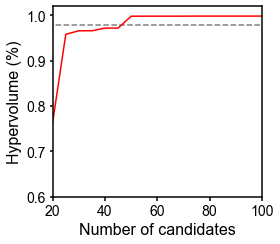

In [69]:
plt.figure(figsize=(4,3.5))
plt.rc('font',family='Arial',weight='normal')
font1 = {'family' : 'Arial',
'weight' : 'normal',
'size'   : 16,
}
plt.plot(g,h,color='r',linestyle='-',linewidth=1.5,zorder=2)
plt.hlines(0.98,0, 100, "gray",linestyles='--',linewidth=1.5,zorder=0) 
title='Number of candidates'
title1='Hypervolume (%)'
plt.xlabel(title,font1 )
plt.ylabel(title1,font1 )
plt.xlim((20, 100))
plt.ylim((0.6, 1.02))
my_x_ticks = np.arange(20,101,20)
my_y_ticks = np.arange(0.6, 1.01,0.1)
plt.xticks(my_x_ticks,size=14)
plt.yticks(my_y_ticks,size=14)
plt.tick_params(width=1.5)
bwith = 1.5
TK = plt.gca()
TK.spines['bottom'].set_linewidth(bwith)
TK.spines['left'].set_linewidth(bwith)
TK.spines['top'].set_linewidth(bwith)
TK.spines['right'].set_linewidth(bwith)
plt.savefig(r'../HV_ParMEI.png', dpi=300,transparent=True,bbox_inches = 'tight')
plt.tight_layout()
plt.show()